In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data = pd.read_csv("dataset_sdn.csv")
y_1 = data['label']
X_1 = data.drop('label', axis=1) 
X_1 = pd.get_dummies(X_1, columns=['src', 'dst', 'Protocol'], drop_first=True)

In [5]:
df_normal = pd.read_csv("Normal_data.csv")
df_metasploitable = pd.read_csv("metasploitable-2.csv")
df_OVS = pd.read_csv("OVS.csv")

In [6]:
df_combined = pd.concat([df_normal, df_metasploitable, df_OVS], axis=0, ignore_index=True)
X_2 = df_combined.drop(columns=["Label"])  
y_2 = df_combined["Label"]  


In [5]:
model = tf.keras.Sequential()
# Нормализация данных
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [ ]:
import math
# Для преобразования данных в 3D-тензор для RNN
total_elements = X_train.size
# Подбираем timesteps и features так, чтобы total_elements % (timesteps*features) == 0
possible_pairs = []
for ts in range(5, 20):  # перебираем возможные timesteps
    for f in range(5, 20):  # перебираем возможные features
        if total_elements % (ts * f) == 0:
            possible_pairs.append((ts, f))

print("Возможные пары (timesteps, features):", possible_pairs)

Возможные пары (timesteps, features): [(7, 8), (7, 16), (8, 7), (8, 14), (14, 8), (14, 16), (16, 7), (16, 14)]


In [7]:
# Преобразование в 3D-тензор для RNN [samples, timesteps, features]
# Предположим, что каждый образец - это 10 временных шагов по 20 признаков
timesteps = 7 # Каждый образец по 7 временных шагов
features = 8
print(features)
X_train = X_train.reshape((-1, timesteps, features))
X_test = X_test.reshape((-1, timesteps, features))

8


In [ ]:
#  Создание модели SimpleRNN
model_SimpleRNN = Sequential([
    SimpleRNN(64, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # бинарная классификация
])

model_SimpleRNN.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
history_rnn = model_SimpleRNN.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6076 - loss: 0.6781 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6095 - loss: 0.6690 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6122 - loss: 0.6678 - val_accuracy: 0.6096 - val_loss: 0.6690
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6103 - loss: 0.6687 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 5/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6081 - loss: 0.6696 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 6/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6104 - loss: 0.6686 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 7/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.6079 - loss: 0.6697 - val_accuracy: 0.6096 - val_loss: 0.6689
Epoch 8/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6097 - loss: 0.6689 -

In [10]:
test_loss, test_acc = model_SimpleRNN.evaluate(X_test, y_test)
print(test_acc)

653/653 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6092 - loss: 0.6691
0.6096123456954956


In [11]:
# Создание модели GRU
model_GRU = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=True),
    BatchNormalization(), # для стабилизации обучения
    Dropout(0.3),
    
    GRU(32),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # бинарная классификация
])
model_GRU.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [12]:
# Ранняя остановка при переобучении
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение
history_gru = model_GRU.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6104 - loss: 0.6755 - precision: 0.3636 - recall: 0.0011 - val_accuracy: 0.6096 - val_loss: 0.6689 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.6097 - loss: 0.6689 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6096 - val_loss: 0.6689 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6105 - loss: 0.6685 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6096 - val_loss: 0.6689 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6102 - loss: 0.6687 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6096 - val_loss: 0.6690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6086 - loss: 0.6694 - p

In [13]:
# Создание модели LSTM
model_LSTM = Sequential([
    LSTM(128, input_shape=(timesteps, features), 
    return_sequences=True, 
    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')  # бинарная классификация
])

# Компиляция модели с оптимизатором и метриками
optimizer = Adam(learning_rate=0.0001)
model_LSTM.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Ранняя остановка при переобучении
early_stop = EarlyStopping( monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)

In [14]:
# Обучение модели
history_lstm = model_LSTM.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    class_weight={0: 1, 1: 3}  #  больший вес для класса атак
)

Epoch 1/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.3918 - auc: 0.5012 - loss: nan - precision: 0.3905 - recall: 0.9975 - val_accuracy: 0.3904 - val_auc: 0.5000 - val_loss: nan - val_precision: 0.3904 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.3950 - auc: 0.4962 - loss: nan - precision: 0.3950 - recall: 1.0000 - val_accuracy: 0.3904 - val_auc: 0.5000 - val_loss: nan - val_precision: 0.3904 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.3900 - auc: 0.5020 - loss: nan - precision: 0.3900 - recall: 1.0000 - val_accuracy: 0.3904 - val_auc: 0.5000 - val_loss: nan - val_precision: 0.3904 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/10
2609/2609 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.3920 - auc: 0.4984 - loss: nan - precision: 0.3920 - recall: 1.0000 - val_accuracy: 0.3904 - val_auc: 0.5000 - val_loss: nan - val

In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_model_history(history, model_name, filename=None):
    plt.figure(figsize=(12, 5))
    
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='-')
    plt.title(f'{model_name}\nTraining & Validation Accuracy', fontsize=12, pad=20)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='red', linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
    plt.title(f'{model_name}\nПотеря обучения и валидации', fontsize=12, pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

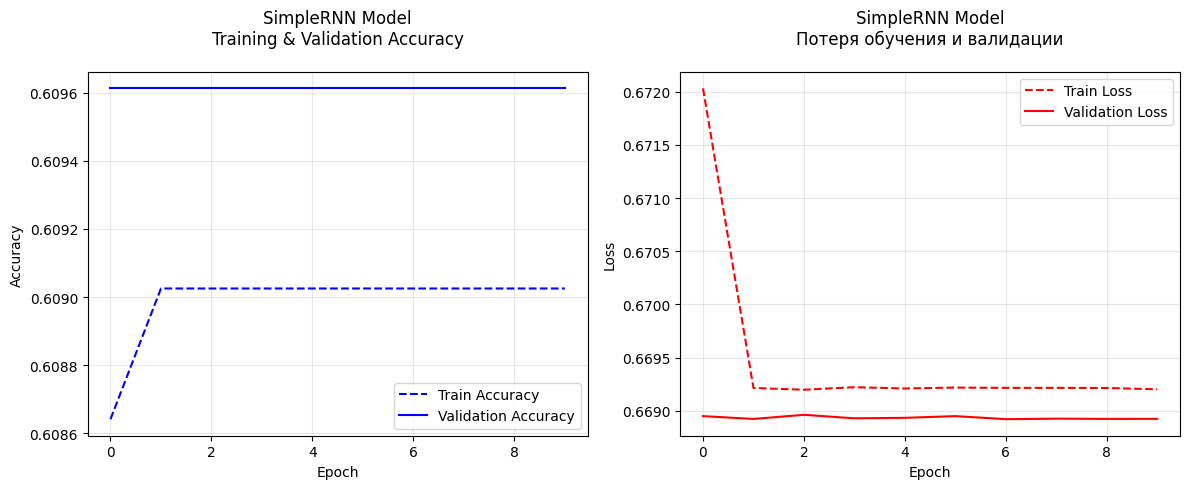

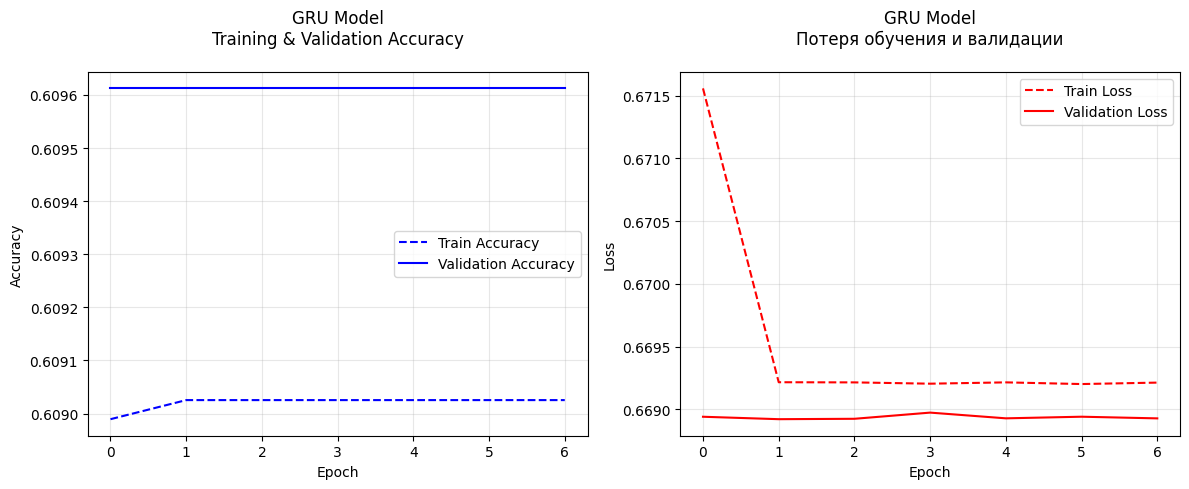

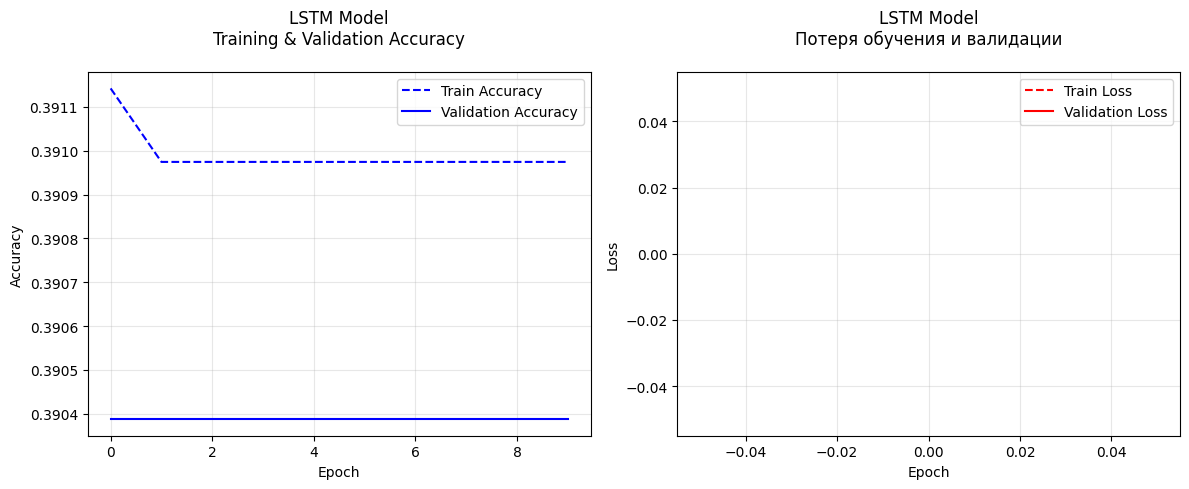

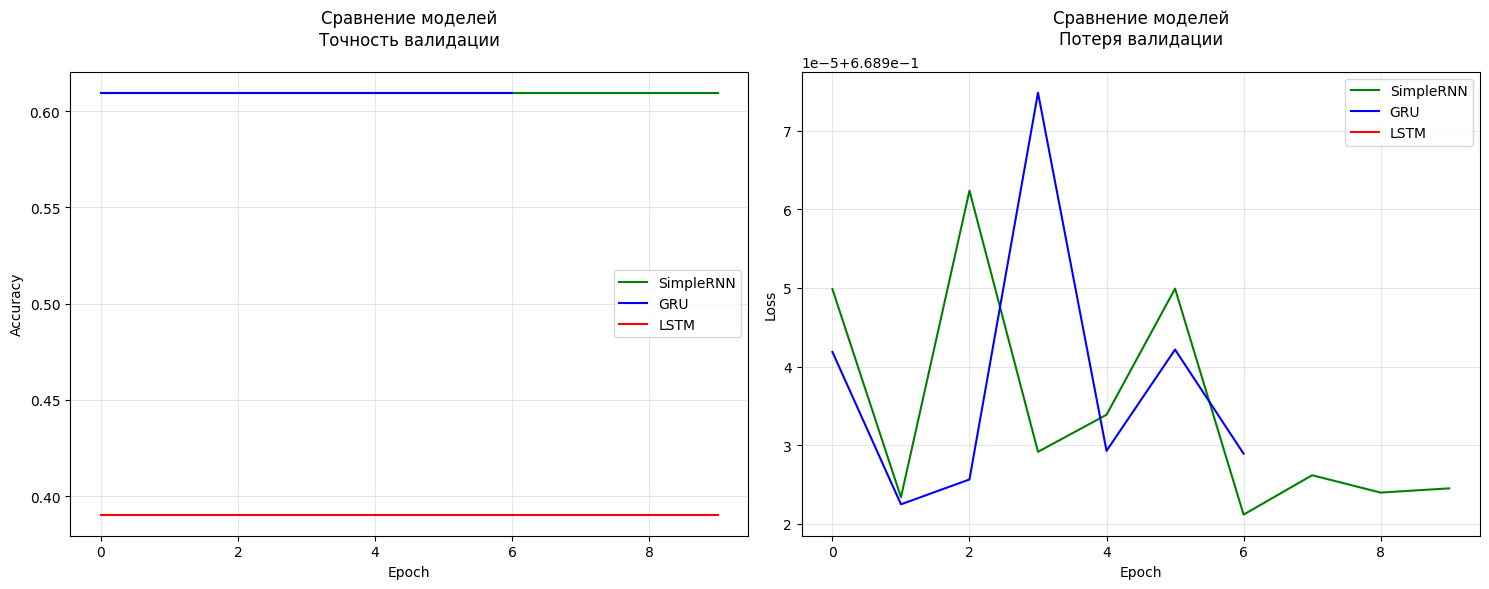

In [17]:
# Генерируем графики для каждой модели
plot_model_history(history_rnn, 'SimpleRNN Model', 'simple_rnn_metrics.png')
plot_model_history(history_gru, 'GRU Model', 'gru_metrics.png')
plot_model_history(history_lstm, 'LSTM Model', 'lstm_metrics.png')

# Создаем сводный график для сравнения
plt.figure(figsize=(15, 6))

# Сравнение Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='SimpleRNN', color='green')
plt.plot(history_gru.history['val_accuracy'], label='GRU', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM', color='red')
plt.title('Сравнение моделей\nТочность валидации', fontsize=12, pad=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['val_loss'], label='SimpleRNN', color='green')
plt.plot(history_gru.history['val_loss'], label='GRU', color='blue')
plt.plot(history_lstm.history['val_loss'], label='LSTM', color='red')
plt.title('Сравнение моделей\nПотеря валидации', fontsize=12, pad=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison_ddos.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
df_combined['Src ip'] = df_combined['Src IP'].apply(lambda x: int(''.join(x.split('.'))))
df_combined['Dst ip'] = df_combined['Dst IP'].apply(lambda x: int(''.join(x.split('.'))))
df_combined['Flow_ID_Part1'] = df_combined['Flow ID'].apply(lambda x: int(x.split('.')[1]))

df_combined = df_combined.drop(columns=['Src IP'])
df_combined = df_combined.drop(columns=['Dst IP'])
df_combined = df_combined.drop(columns=['Flow ID'])

In [8]:
df_combined['Timestamp'] = pd.to_datetime(df_combined['Timestamp'], format='mixed')
# Извлечение полезных признаков
df_combined['Year'] = df_combined['Timestamp'].dt.year
df_combined['Month'] = df_combined['Timestamp'].dt.month
df_combined['Day'] = df_combined['Timestamp'].dt.day
df_combined['Hour'] = df_combined['Timestamp'].dt.hour
df_combined['Minute'] = df_combined['Timestamp'].dt.minute
df_combined['Second'] = df_combined['Timestamp'].dt.second
df_combined['DayOfWeek'] = df_combined['Timestamp'].dt.dayofweek  # День недели (0 - понедельник, 6 - воскресенье)

# Удаление исходной колонки Timestamp
df_combined = df_combined.drop(columns=['Timestamp'])

In [9]:
X_2 = df_combined.drop(columns=["Label"])  
y_2 = df_combined["Label"]  
# Нормализация данных
scaler = StandardScaler()
X_2 = scaler.fit_transform(X_2)
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [10]:
import math
total_elements = X_train.size
possible_pairs = []
for ts in range(5, 20):
    for f in range(5, 20):
        if total_elements % (ts * f) == 0:
            possible_pairs.append((ts, f))

print("Возможные пары (timesteps, features):", possible_pairs)

Возможные пары (timesteps, features): []


In [22]:
X_train.size

24484879

In [11]:
def smart_reshape(X, preferred_timesteps=10):
    n_features = X.shape[1]
    
    # Если features меньше preferred_timesteps
    if n_features < preferred_timesteps:
        return X.reshape(-1, 1, n_features)  # [samples, 1, features]
    
    # Пытаемся разделить на preferred_timesteps
    if n_features % preferred_timesteps == 0:
        return (preferred_timesteps, n_features // preferred_timesteps)
    
    # Ищем ближайший делитель
    for ts in [preferred_timesteps, 5, 10, 20, n_features]:
        if n_features % ts == 0:
            return (ts, n_features // ts)
    
    # Последний вариант - padding
    remainder = n_features % preferred_timesteps
    padding = preferred_timesteps - remainder
    X_padded = np.pad(X, ((0,0), (0,padding)), mode='constant')
    return (preferred_timesteps, (n_features + padding) // preferred_timesteps)
print(smart_reshape(X_train))

(89, 1)


In [12]:
# Преобразование в 3D-тензор для RNN [samples, timesteps, features]
# Предположим, что каждый образец - это 10 временных шагов по 20 признаков
timesteps = 89 # Каждый образец по 7 временных шагов
features = 1
X_train = X_train.reshape((-1, timesteps, features))
X_test = X_test.reshape((-1, timesteps, features))

In [ ]:
#  Создание модели SimpleRNN
model_SimpleRN_mul = Sequential([
    SimpleRNN(64, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(9, activation='softmax') #многоклассовая
])

model_SimpleRN_mul.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Преобразование меток в числовые значения
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
# Преобразование в формат one-hot encoding

In [15]:
print("Тип X_train:", X_train.dtype)
print("Тип y_train:", y_train.dtype)
print("Тип X_train:", X_test.dtype)
print("Тип y_train:", y_test.dtype)
# Должны быть float32 и int32 соответственно

Тип X_train: float64
Тип y_train: int32
Тип X_train: float64
Тип y_train: int32


In [28]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [29]:
history_rnn_2 = model_SimpleRN_mul.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 139s 16ms/step - accuracy: 0.9708 - loss: 0.1097 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 2/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9999 - val_loss: 6.4667e-04
Epoch 3/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 130s 15ms/step - accuracy: 0.9986 - loss: 0.0056 - val_accuracy: 0.9999 - val_loss: 7.2378e-04
Epoch 4/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 127s 15ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.9999 - val_loss: 8.0984e-04
Epoch 5/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 119s 14ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 6/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9990 - val_loss: 0.0042
Epoch 7/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 130s 15ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9999 - val_loss: 9.0894e-04
Epoch 8/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 126s 15ms/s

In [30]:
print("Форма X_train до преобразования:", X_train.shape)
print("Форма y_train:", y_train.shape)

Форма X_train до преобразования: (275111, 89, 1)
Форма y_train: (275111,)


In [31]:
from tensorflow.keras import Input

In [32]:
# Создание модели GRU
# Создание модели GRU с явным указанием input_shape
model_GRU_mul = Sequential([
    Input(shape=(timesteps, features)),  # Четкое определение формы входа
    GRU(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(9, activation='softmax')
])

model_GRU_mul.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# Ранняя остановка при переобучении
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение
history_gru_2 = model_GRU_mul.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 164s 19ms/step - accuracy: 0.9554 - loss: 0.1617 - val_accuracy: 0.9996 - val_loss: 0.0017
Epoch 2/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 201s 23ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9999 - val_loss: 9.0721e-04
Epoch 3/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 182s 21ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9999 - val_loss: 0.0011
Epoch 4/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 171s 20ms/step - accuracy: 0.9998 - loss: 7.8220e-04 - val_accuracy: 0.9999 - val_loss: 0.0012
Epoch 5/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 196s 23ms/step - accuracy: 0.9998 - loss: 6.3172e-04 - val_accuracy: 0.9999 - val_loss: 0.0015
Epoch 6/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 190s 22ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9999 - val_loss: 0.0012
Epoch 7/10
8598/8598 ━━━━━━━━━━━━━━━━━━━━ 166s 19ms/step - accuracy: 0.9999 - loss: 4.7474e-04 - val_accuracy: 0.9999 - val_loss: 0.0012


In [34]:
# Создание модели LSTM
model_LSTM_mul = Sequential([
    Input(shape=(timesteps, features)),
    LSTM(128, 
    return_sequences=True, 
    kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(9, activation='softmax') # многоклассовая
])

# Компиляция модели с оптимизатором и метриками
optimizer = Adam(learning_rate=0.0001)
model_LSTM_mul.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Ранняя остановка при переобучении
early_stop = EarlyStopping( monitor='val_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1
)


In [ ]:
# Обучение модели
history_lstm_2 = model_LSTM_mul.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    class_weight={0: 1, 1: 3, 2:3, 3:3, 4:3, 5:3, 6:3, 7:3, 8:3}  #  больший вес для класса атак
)

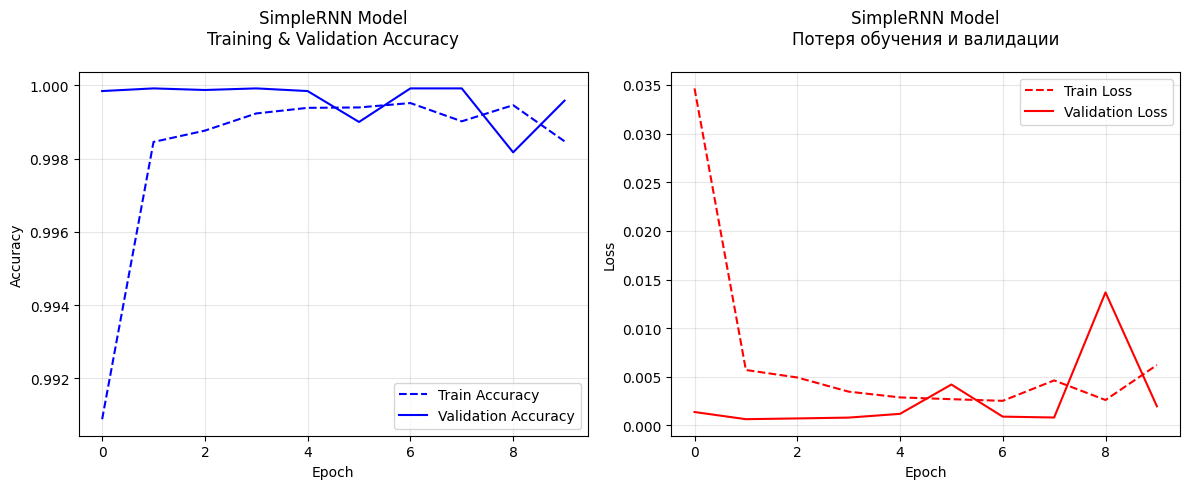

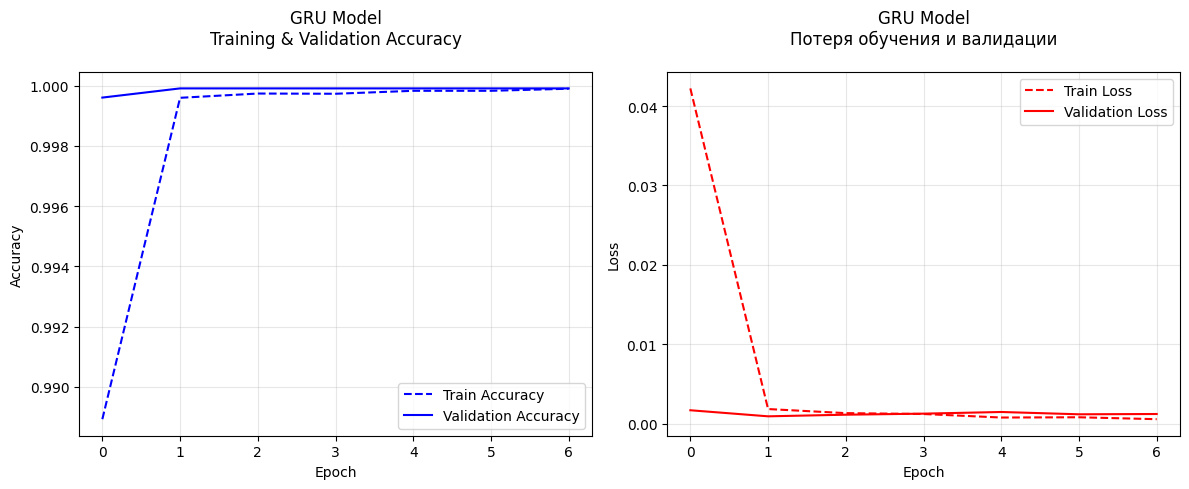

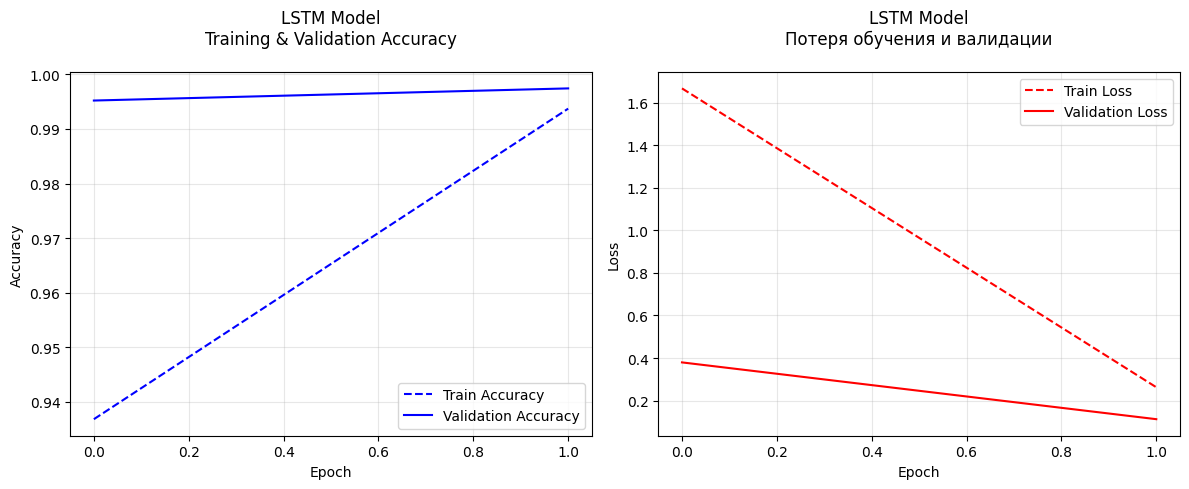

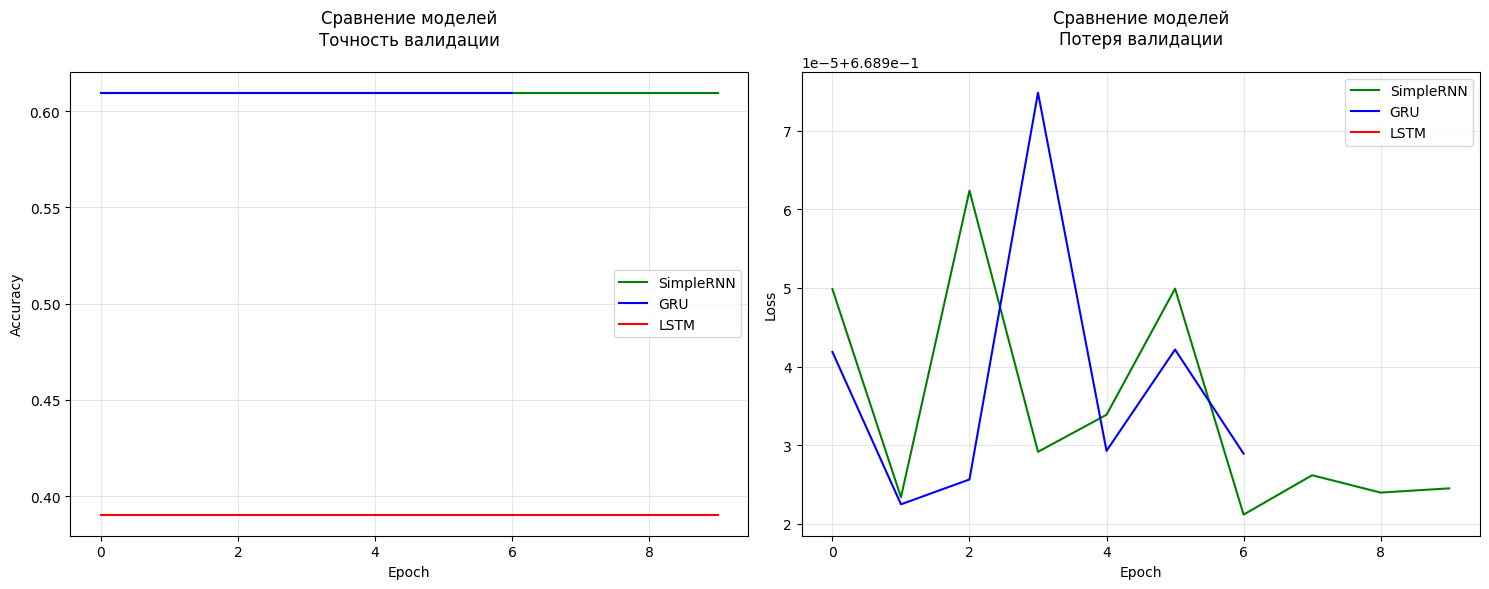

In [36]:
# Генерируем графики для каждой модели
plot_model_history(history_rnn_2, 'SimpleRNN Model', 'simple_rnn_metrics_insdn.png')
plot_model_history(history_gru_2, 'GRU Model', 'gru_metrics_insd.png')
plot_model_history(history_lstm_2, 'LSTM Model', 'lstm_metrics_insd.png')

# Создаем сводный график для сравнения
plt.figure(figsize=(15, 6))

# Сравнение Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='SimpleRNN', color='green')
plt.plot(history_gru.history['val_accuracy'], label='GRU', color='blue')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM', color='red')
plt.title('Сравнение моделей\nТочность валидации', fontsize=12, pad=20)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['val_loss'], label='SimpleRNN', color='green')
plt.plot(history_gru.history['val_loss'], label='GRU', color='blue')
plt.plot(history_lstm.history['val_loss'], label='LSTM', color='red')
plt.title('Сравнение моделей\nПотеря валидации', fontsize=12, pad=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models_comparison_insd.png', dpi=300, bbox_inches='tight')
plt.show()